<a href="https://colab.research.google.com/github/AnthonyGouffier/PFT/blob/main/Copie_de_dm_GOUFFIER_Anthony.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification d'émotions dans la parole avec un modèle Bayésien naïf.

Dans ce travail, vous allez travailler sur un corpus de parole où les locuteurs actent des émotions sur un texte prédéfini. Ce corpus s'appelle Emo-DB, et la documentation complète est accessible ici : http://emodb.bilderbar.info/docu/ et la base de donnée est accessible sur la plateforme Kaggle (https://www.kaggle.com/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb)

10 locuteurs ont été enregistrés. 6 seront utilisés pour apprendre un modèle Bayésien naïf, les 4 locuteurs restant serviront à valider votre modèle. Nous aurons donc une évaluation indépendante du locuteur.

A l'origine, 6 émotions ont été exprimées lors de l'enregistrement du corpus. Pour simplifier le problème, nous avons réduit à deux classes notre problème de classification :
* C1 : colère, ennui, peur
* C2 : neutre, surprise, joie

In [ ]:
from pathlib import Path
import pandas as pd
import scipy.io.wavfile as wav
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

!pip install opensmile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.0/996.0 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 19.8 MB/s eta 0:00:00


## 1) Feature extraction (à lire et exécuter que pour la partie 4)

Vous n'avez rien à faire dans cette section. Je vous la laisse pour comprendre comment sont construits les différents fichiers que vous aurez à traiter par la suite.

Pour construire un modèle à partir d'une base de donnée audio, il faut extraire des descripteurs du signal de parole. Généralement ces descripteurs sont issus de la théorie du traitement numérique du signal et du modèle source-filtre de la parole.

Nous considérons ici, l'extraction des descripteurs comme une boîte noire qui prend en entrée un signal audio (fichier wav) et retourne un vecteur de caractéristiques pour l'ensemble du segment. La taille du vecteur ne dépend pas de la durée du signal audio.

La boîte noire que nous allons utiliser est celle d'OpenSmile (https://audeering.github.io/opensmile-python/). Le contenu des vecteurs de caractéristiques varie suivant la configuration choisie. Une des configurations les plus utilisées s'appelle eGeMAPS, c'est celle que nous utiliserons. Elle permet de représenter un segment de parole émotionnelle sous forme d'un vecteur de 88 valeurs continues.

In [ ]:
import opensmile
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)
# affichage des noms des descripteurs audio qui sont extraits pour chaque fichier audio.
feat = smile.feature_names
print(','.join(feat))

F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,loudness_sma3_amean,loudness_sma3_stddevNorm,loudness_sma3_percentile20.0,loudness_sma3_percentile50.0,loudness_sma3_percentile80.0,loudness_sma3_pctlrange0-2,loudness_sma3_meanRisingSlope,loudness_sma3_stddevRisingSlope,loudness_sma3_meanFallingSlope,loudness_sma3_stddevFallingSlope,spectralFlux_sma3_amean,spectralFlux_sma3_stddevNorm,mfcc1_sma3_amean,mfcc1_sma3_stddevNorm,mfcc2_sma3_amean,mfcc2_sma3_stddevNorm,mfcc3_sma3_amean,mfcc3_sma3_stddevNorm,mfcc4_sma3_amean,mfcc4_sma3_stddevNorm,jitterLocal_sma3nz_amean,jitterLocal_sma3nz_stddevNorm,shimmerLocaldB_sma3nz_amea

In [ ]:
corpus_dir = '/Users/tahon/Documents/Recherche/Corpus/emodb/wav/'
# dictionnaire de correspondance entre les classes d'émotion en allemand vers anglais
# emo2emo = {'W':'A', 'L':'B', 'E':'D', 'A':'F', 'F':'H', 'T':'S', 'N':'N'}
# dictionnaire de correspondance entre les classes d'émotion en allemand vers nos 2 classes.
# La correspondance na n'est pas prise en compte dans l'extraction des descripteurs.
emo2cl = {'W':'NEG', 'L':'IDL', 'E':'NEG', 'A':'NEG', 'F':'IDL', 'T':'NEG', 'N':'IDL'}


def write_extract_features(corpus_dir, spk_list, csvfile):
    """
        Cette fonction crée un fichier contenant l'ensemble des descripteurs obtenus pour chaque fichier audio,
        ainsi que la classe d'émotion correspondante: Name,desc1,desc2,...,desc88,Emo
        - corpus_dir: chemin vers les fichiers audio
        - spk_list: liste des locuteurs considérés pour la création du fichier
        - csvfile: nom du fichier
    """
    header = 'Name,'+','.join(feat)+',Emo\n'
    with open(csvfile, 'w') as f:
        f.write(header)
        for file in Path(corpus_dir).glob('*.wav'):

            tab = str(file).split('/')[-1]
            spk = tab[:2]
            if spk not in spk_list:
                continue
            text = tab[2:5]
            emo = emo2cl[tab[5]]
            if emo == 'na':
                continue
            sr, y = wav.read(corpus_dir + tab)
            x = smile.process_signal(y,sr)
            f.write(tab + ',')
            f.write(','.join(str(x.values[0][i]) for i in range(88)))
            f.write(',' + emo + '\n')

--------------------------
A partir de maintenant, nous pouvons extraire l'ensemble des descripteurs des ensembles d'apprentissage et de test fichier par fichier.

Si vous souhaitez modifier la répartition des classes émotionnelles, et/ou faire une classification à plusieurs classes, vous devrez regénérer ces fichiers. Mais pour la partie suivante, vous pouvez récupérer les fichiers directement sur le dépôt UMTICE.

### Extract train set features

In [ ]:
#spk_train = ['03', '08', '09', '10', '11', '12']
#write_extract_features(corpus_dir, spk_train, 'emodb_train.csv')

### Extract test features

In [ ]:
#spk_test = ['13', '14', '15', '16']
#write_extract_features(corpus_dir, spk_test, 'emodb_test.csv')

## 2) Analyse des données

Avant de choisir quel modèle vous souhaitez mettre en place, il va être nécessaire d'étudier les données pour voir comment elles sont organisées. Dans un premier temps on évaluera si tous les descripteurs sont pertinents : est-ce que certains sont très fortement corrélés ? d'autres ont peut-être une variance presque nulle, etc... Dans un second temps on cherchera à savoir la loi de probabilité qui est la plus adaptée pour décrire la distribution des données.

### Chargement des données d'apprentissage et de test

Pour charger les données on utilisera la librairie pandas. Si vous êtes plus à l'aise avec numpy, c'est possible de convertir les DataFrame de pandas en numpy avec la méthodes `to_numpy()`

Vous pouvez charger directement les données fournies au format CSV avec le code ci-dessous. Ainsi vous n'avez pas besoin d'effectuer le calcul des descripteurs et d'écrire le CSV, cette étape (partie 1) est déjà faite pour ce TP.

In [ ]:
# on récupère deux panda dataframe contenant les noms des fichiers, les descripteurs associés et l'émotion réelle.
train_data = pd.read_csv('emodb_train.csv')
test_data = pd.read_csv('emodb_test.csv')

# to get column names
feat_names = train_data.columns.values

**Q1** À partir des données d'apprentissage uniquement, tracer la distribution de quelques descripteurs. Donner le type des descripteurs (continu, discret), et la loi (ou les lois) qui permet de décrire au mieux ces données. Vous justifierez au maximum votre réponse. Il est possible que certains descripteurs soient inutiles, vous prendrez soin de nettoyer vos données avant de passer à la suite.

In [ ]:
constant_columns = []

for name in feat_names:
  sameName = np.all(test_data[name] == test_data[name][0])
  if(not sameName):
    constant_columns.append(name)

test_data_clean = test_data.filter(constant_columns)
train_data_clean = train_data.filter(constant_columns)

identifie les colonnes non constantes et crée de nouveaux DataFrames test_data_clean et train_data_clean ne contenant que ces colonnes.

**Q2** Maintenant que vos données sont un peu plus propres, vous pouvez estimer à quel point les descripteurs sont indépendants. Proposer pour cela une méthodologie d'analyse en justifiant vos choix. En déduire certaines propriétés des descripteurs par rapport à nos données d'apprentissage.

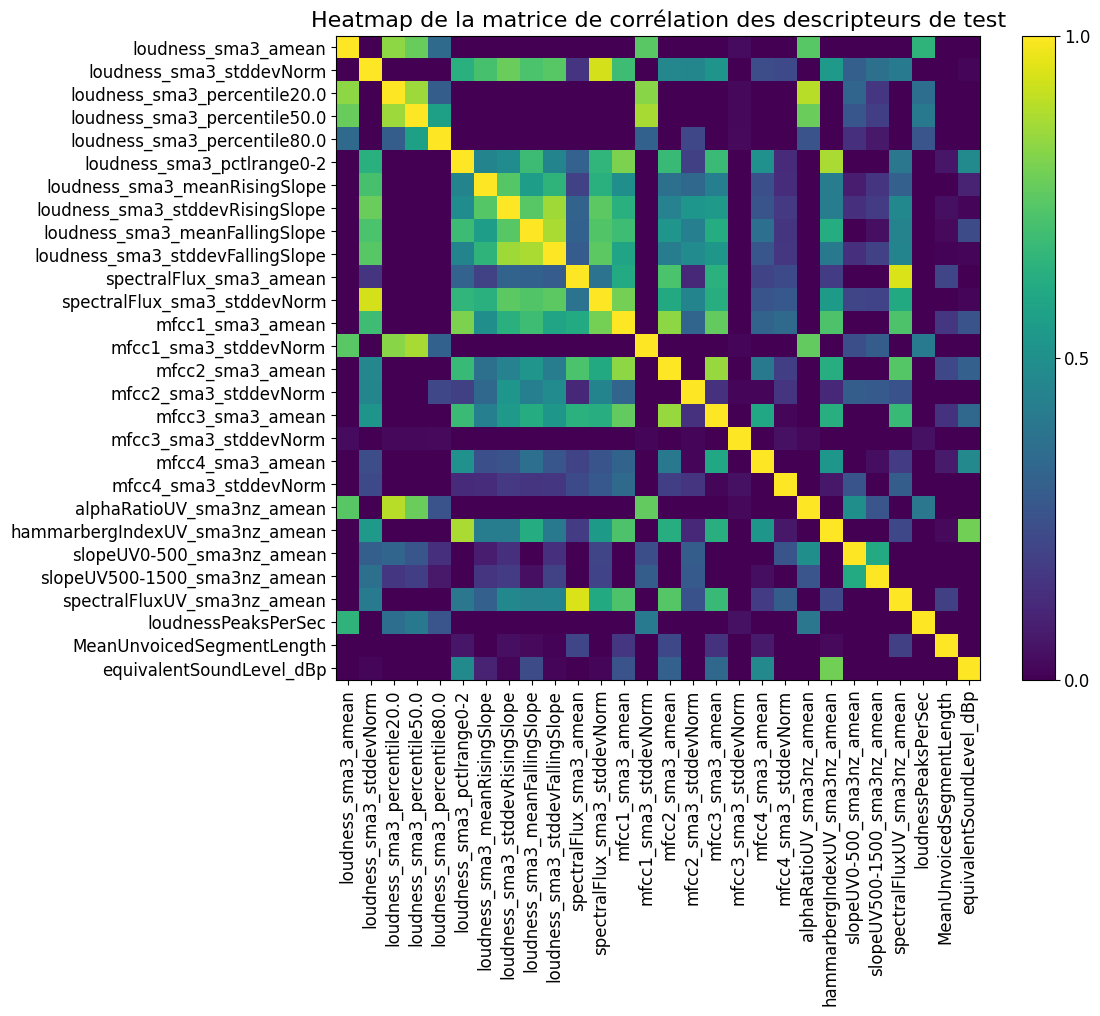

In [ ]:
# Exclure les colonnes de chaînes de caractères
sans_chaine = train_data_clean.drop(columns=["Name", "Emo"])

# Calcul de la matrice de corrélation
matrice_correlation = sans_chaine.corr()

# Visualisation de la matrice de corrélation avec une heatmap
plt.figure(figsize=(12, 10))
plt.title('Heatmap de la matrice de corrélation des descripteurs de test', fontsize=16)
heatmap = plt.imshow(matrice_correlation, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)

# Ajout d'une barre de couleur
cbar = plt.colorbar(heatmap, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=12)

# Ajout des étiquettes des descripteurs
plt.xticks(ticks=np.arange(len(matrice_correlation.columns)), labels=matrice_correlation.columns, rotation=90, fontsize=12)
plt.yticks(ticks=np.arange(len(matrice_correlation.columns)), labels=matrice_correlation.columns, fontsize=12)
plt.tight_layout()
plt.show()

Exclu les colonnes Name et Emo.
Calculé la matrice de corrélation des descripteurs restants.
Visualise cette matrice avec une heatmap.

## 3) Construction d'un modèle Bayesien Naïf

Dans cette seconde partie vous devez implémenter un modèle Bayésien Naïf. Les paramètres du modèles, c'est-à-dire les paramètres correspondant à la loi de probabilité que vous allez utilisée, seront obtenus à partir des données d'apprentissage.

Les données de test serviront à évaluer la qualité en termes de performance de votre modèle. Vous ne devez en AUCUN cas les utiliser pour déterminer les paramètres du modèle.


**Q3** A partir des éléments de code donnés ci-dessous, calculer la probabilité a priori pour chacune des classes.

In [ ]:
# Calcul de la répartition des classes
repartition_classe = train_data_clean.groupby('Emo').size()

# Calcul du total des occurrences
total = repartition_classe.sum()

# Calcul des probabilités a priori
res = repartition_classe / total

# Affichage des probabilités a priori
print(res)

Emo
IDL    0.442446
NEG    0.557554
dtype: float64


calcule les probabilités *a prioris* pour Emo

**Q4** Pour chaque descripteur déterminer les paramètres de loi à partir des segments émotionnels de la base d'apprentissage. On rappelle que dans le cas Bernoulli, il faut déterminer la probabilité de succès de l'événement. Dans le cas multinomial, il faut déterminer la moyenne et l'écart-type de la densité de probabilité.


In [ ]:
mu = 0
ecart_type = 0
for column in sans_chaine.columns:
    mu = sans_chaine[column].mean()
    ecart_type = sans_chaine[column].std()
    print(column + ' :')
    print('\tµ =', mu)
    print('\tσ =', ecart_type)
print('Emo :')
print('\tsucces = IDL')
print('\techec = NEG')
print('\tp = 0.442446')

loudness_sma3_amean :
	µ = 6.209850128776979
	σ = 0.18041990176820943
loudness_sma3_stddevNorm :
	µ = 0.03410884595683453
	σ = 0.06360010973442344
loudness_sma3_percentile20.0 :
	µ = 6.14323981618705
	σ = 0.3222068307056856
loudness_sma3_percentile50.0 :
	µ = 6.267022823741007
	σ = 0.026771256763039212
loudness_sma3_percentile80.0 :
	µ = 6.328684720503596
	σ = 0.01173048481911978
loudness_sma3_pctlrange0-2 :
	µ = 0.18544491394604318
	σ = 0.3189608596255355
loudness_sma3_meanRisingSlope :
	µ = 9.933241171877123
	σ = 16.343467925325125
loudness_sma3_stddevRisingSlope :
	µ = 4.567283316546762
	σ = 6.733152370725469
loudness_sma3_meanFallingSlope :
	µ = 5.908510859543166
	σ = 5.384887602209919
loudness_sma3_stddevFallingSlope :
	µ = 4.459102325658273
	σ = 6.879204794267977
spectralFlux_sma3_amean :
	µ = 3.691802878417266
	σ = 0.13064938806629842
spectralFlux_sma3_stddevNorm :
	µ = 0.09605309067985611
	σ = 0.058231244029220065
mfcc1_sma3_amean :
	µ = -8.185604738848921
	σ = 1.00929919185770


**Q5** Rappeler l'hypothèse naïve. Qu'en pensez-vous par rapport à l'analyse des données faites dans la partie 2 ?



L'hypothèse naïve dit que toutes les caractéristiques sont indépendantes. Mais, comme vu dans la partie 2, certains descripteurs sont corrélés, donc ce n'est pas toujours vrai. Même si notre modèle ne sera pas parfait, il peut quand même bien marcher dans la plupart des cas.



**Q6** Construire une fonction qui calcule la vraisemblance d'un segment de test d'appartenir à la classe IDL ou NEG. Elle prendra en entrée les données d'apprentissage et un segment de test.


In [ ]:
# Définition des probabilités a priori
prob1 = 0.44
prob2 = 0.55

def calcul_vraisemblance(segment, data_sans_chaine=sans_chaine, data_complet=train_data_clean):
    valeurs_test = np.array([segment[col] for col in data_sans_chaine.columns])
    vraisemblance_idl = 1
    vraisemblance_neg = 1

    for idx, col in enumerate(data_sans_chaine.columns):
        mean_idl = data_complet[data_complet["Emo"] == "IDL"][col].mean()
        std_idl = data_complet[data_complet["Emo"] == "IDL"][col].std()
        mean_neg = data_complet[data_complet["Emo"] == "NEG"][col].mean()
        std_neg = data_complet[data_complet["Emo"] == "NEG"][col].std()

        vraisemblance_idl *= (1 / np.sqrt(2 * np.pi * std_idl)) * (np.exp(-((valeurs_test[idx] - mean_idl) ** 2) / (2 * std_idl**2)))
        vraisemblance_neg *= (1 / np.sqrt(2 * np.pi * std_neg)) * (np.exp(-((valeurs_test[idx] - mean_neg) ** 2) / (2 * std_neg**2)))

    return vraisemblance_idl * prob1, vraisemblance_neg * prob2



**Q7** Pour un segment de test dont on ne connait pas la classe émotionnelle, déterminer le maximum de vraisemblance.

In [ ]:
vraissemblance = max(calcul_vraisemblance(test_data.iloc[1]))
print(vraissemblance)

1.4209164412150132e-06


affiche la plus grande des vraisemblances


**Q8** A partir de la vraisemblance et de la probabilité a priori, calculer la probabilité a posteri que le segment de test à partienne à une classe ou l'autre. Comparer votre résultat avec l'émotion réelle telle qu'annotée dans le corpus.

In [ ]:
# Calcul des vraisemblances pour la deuxième ligne des données de test
vraisemblance_idl, vraisemblance_neg = calcul_vraisemblance(test_data.iloc[1])

# Calcul des probabilités a posteriori
after_idl = vraisemblance_idl * prob1
after_neg = vraisemblance_neg * prob2
print(after_idl, after_neg)

6.252032341346059e-07 9.148720881107718e-08


**Q9** Evaluer votre modèle en calculant le taux de bonnes réponses (accuracy) obtenu sur l'ensemble de test, c'est-à-dire le nombre de bonnes réponses sur le nombre total de segments de test. Vous deverez trouver un score légèrement supérieur à 50%.

In [ ]:
cpt = 0
nb = int(test_data_clean['Name'].count())
for i in range(nb):
  # Use the function 'calcul_vraisemblance' instead of the variable 'vraissemblance'
  vraissemblance_idl, vraissemblance_neg = calcul_vraisemblance(test_data_clean.iloc[i])
  if(vraissemblance_idl > vraissemblance_neg):
    if(test_data.iloc[i]['Emo'] == 'IDL'):
      cpt += 1
  else:
    if(test_data.iloc[i]['Emo'] == 'NEG'):
      cpt += 1

print(cpt/nb*100)

56.03112840466926


## 4) Comparaison de vos résultats avec sklearn

Enfin, je vous propose de comparer votre modèle avec une version implémentée dans la librairie `sklearn`. Plusieurs types de modèles sont possibles à choisir en fonction de vos données et votre problème: `MultinomialNB`, `GaussianNB`, `BernoulliNB`, etc...

`sklearn` fourni également un certain nombre de métriques très utiles en machine learning. Parmi celle-ci, la plus complète et adaptée aux problèmes de classification est la visualisation de la matrice de confusion. Cette matrice ($2 \times 2$ dans notre cas), permet de voir le nombre de segment correctement classés par classe.

In [ ]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

L'apprentissage d'un modèle se fait avec les variables suivantes:
* `x_train`: matrice correspondant aux données (en lignes) et leurs descripteurs (en colonnes) pour **l'apprentissage** du modèle
* `y_train`: labels correspondant aux classes associés à chaque donnée d'apprentissage (vecteur)
* `x_test`: matrice correspondant aux données (en lignes) et leurs descripteurs (en colonnes) pour **l'évaluation** du modèle
* `y_pred`: labels prédits par le modèle sur les données d'évaluation `x_test`
* `y_test`: labels a priori inconnus correspondant aux classes associés à chaque donnée d'évaluation (vecteur)

**Q10** Apprendre un modèle équivalent à celui que vous avez implémenté en partie 3. Comparer les résultats obtenus avec les deux versions.

In [ ]:
### TO COMPLETE


**Q11** Le modèle ne donne pas de très bons résultats. Qu'est-ce qui pose problème à votre avis, quels sont les éléments qui peuvent être améliorés ?

## 4) pour aller plus loin (bonus 2pts)

Dans cette dernière partie, je vous laisse libre de choisir la tâche que vous souhaitez réaliser.
Finalement, vous pouvez rafiner votre modèle avec une approche de votre choix, optimiser les descripteurs, faire une classification à plus que deux classes. Vous pouvez également comparer l'approche avec d'autres types de modèles disponibles dans `sklearn`. Vous pouvez également prendre en compte le genre des locuteurs, ou normaliser vos descripteurs (par exemple pour que les descripteurs soient centrés réduits).

Bon courage!

In [ ]:
### TO COMPLETE
